In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import networkx as nx
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from deepchem.feat import RDKitDescriptors
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

In [2]:
def process_smiles(smiles_list, labels):
    unique_smiles = []
    unique_labels = []
    
    for i, smiles in enumerate(smiles_list):
        if isinstance(smiles, str):
            molecule = Chem.MolFromSmiles(smiles)
            if molecule is not None:  
                canonical_smiles = Chem.MolToSmiles(molecule, canonical=True)
                if canonical_smiles not in unique_smiles:
                    unique_smiles.append(canonical_smiles)
                    unique_labels.append(labels[i])
    
    return unique_smiles, unique_labels


In [3]:
def create_graphs_from_smiles(smiles_list):
    graphs = []
    for smiles in smiles_list:
        molecule = Chem.MolFromSmiles(smiles)
        atoms = molecule.GetAtoms()
        bonds = molecule.GetBonds()

        nodes = [(atom.GetIdx(), {'symbol': atom.GetSymbol(), 
                                  'atomic_num': atom.GetAtomicNum(), 
                                  'atomic_mass': atom.GetMass(),
                                  'num_valence': atom.GetTotalValence(),
                                  'hybridization': atom.GetHybridization(),
                                  'in_ring': atom.IsInRing()})
                 for atom in atoms]

        edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), {'bond_type': bond.GetBondType()})
                 for bond in bonds]

        # Create a graph
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        graphs.append(G)
    return graphs


In [5]:
def featurize_smiles(smiles_list):
    featurizer = RDKitDescriptors()
    features = featurizer.featurize(smiles_list)
    print(f"Number of generated molecular descriptors: {features.shape[1]}")

    features = features[:, ~np.isnan(features).any(axis=0)]
    print(f"Number of molecular descriptors without invalid values: {features.shape[1]}")

    return features

In [6]:
def remove_zero_variance_features(features, threshold=0.0):
    selector = VarianceThreshold(threshold=threshold)
    features = selector.fit_transform(features)
    
    print(f"Number of molecular descriptors after removing zero-variance features: {features.shape[1]}")
    
    return features


In [7]:
def perform_grid_search(X_train, y_train, model, param_grid, cv=5, scoring='r2', n_jobs=-1):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)

    return best_params

In [8]:
def train_test_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_train_mse = mean_squared_error(y_train, y_pred_train)
    model_test_mse = mean_squared_error(y_test, y_pred_test)
    model_train_rmse = model_train_mse ** 0.5
    model_test_rmse = model_test_mse ** 0.5

    model_train_r2 = r2_score(y_train, y_pred_train)
    model_test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"RMSE on train set: {model_train_rmse:.3f}, test set: {model_test_rmse:.3f}.")
    print(f"R^2 on train set: {model_train_r2:.3f}, test set: {model_test_r2:.3f}.\n")


In [10]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt



## HTL

In [105]:
df_htl = pd.read_excel('data/HTL_TABLE.xlsx') 
smiles_list = df_htl['SMILES'].dropna().tolist() 
labels = df_htl['PCE (%)'].dropna().tolist()

unique_smiles, unique_labels = process_smiles(smiles_list, labels)
features = featurize_smiles(unique_smiles)

X = features
X_temp, X_test, y_temp, y_test = train_test_split(X, unique_labels, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True)

Number of generated molecular descriptors: 209
Number of molecular descriptors without invalid values: 197


In [108]:
ranf_reg_htl = RandomForestRegressor()
print("Evaluating Random Forest model.")
train_test_model(ranf_reg_htl, X_train, y_train, X_val, y_val) # Validate the model

# Tune the model based on validation results, and finally test it
print("Final evaluation on test set.")
train_test_model(ranf_reg_htl, X_train, y_train, X_test, y_test)

Evaluating Random Forest model.
RMSE on train set: 1.676, test set: 4.421.
R^2 on train set: 0.860, test set: -0.439.

Final evaluation on test set.
RMSE on train set: 1.738, test set: 3.730.
R^2 on train set: 0.850, test set: 0.077.



Evaluating Random Forest model.


<module 'matplotlib.pyplot' from '/Users/anthojen/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/matplotlib/pyplot.py'>

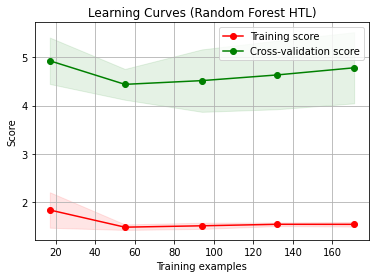

In [109]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

rmse_scorer = make_scorer(rmse)
print("Evaluating Random Forest model.")
title = "Learning Curves (Random Forest HTL)"
plot_learning_curve(ranf_reg_htl, title, X, unique_labels, cv=5, scoring=rmse_scorer)

#### Random Forest Regression HTL

In [45]:
ranf_reg_htl = RandomForestRegressor()
print("Evaluating Random Forest model.")
train_test_model(ranf_reg_htl, X_train, y_train, X_val, y_val) # Validate the model

# Tune the model based on validation results, and finally test it
print("Final evaluation on test set.")
train_test_model(ranf_reg_htl, X_train, y_train, X_test, y_test)

Evaluating Random Forest model.
RMSE on train set: 1.688, test set: 4.597.
R^2 on train set: 0.858, test set: -0.556.

Final evaluation on test set.
RMSE on train set: 1.679, test set: 3.587.
R^2 on train set: 0.860, test set: 0.147.



In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

ranf_reg_htl = RandomForestRegressor(random_state=42)

best_params = perform_grid_search(X_train, y_train, ranf_reg_htl, param_grid)

ranf_reg_htl_best = RandomForestRegressor(**best_params, random_state=42)
print("Evaluating Random Forest model.")
train_test_model(ranf_reg_htl_best, X_train, y_train, X_val, y_val)
print("Final evaluation on test set.")
train_test_model(ranf_reg_htl_best, X_train, y_train, X_test, y_test)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Evaluating Random Forest model.
RMSE on train set: 2.601, test set: 4.416.
R^2 on train set: 0.663, test set: -0.435.

Final evaluation on test set.
RMSE on train set: 2.601, test set: 3.692.
R^2 on train set: 0.663, test set: 0.096.



Evaluating Random Forest model.


<module 'matplotlib.pyplot' from '/Users/anthojen/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/matplotlib/pyplot.py'>

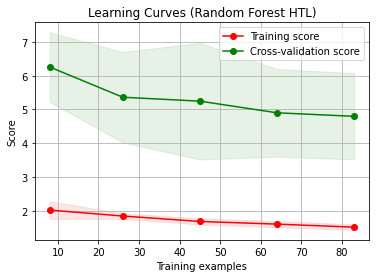

In [81]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

rmse_scorer = make_scorer(rmse)
print("Evaluating Random Forest model.")
title = "Learning Curves (Random Forest HTL)"
plot_learning_curve(ranf_reg_htl, title, X, unique_labels, cv=5, scoring=rmse_scorer)

#### XGBoost Regression HTL

In [87]:
xgb_reg_htl = xgb.XGBRegressor(n_estimators=18, random_state=0) 
print("Evaluating Random Forest model.")
train_test_model(xgb_reg_htl, X_train, y_train, X_val, y_val) 

print("Final evaluation on test set.")
train_test_model(xgb_reg_htl, X_train, y_train, X_test, y_test)

Evaluating Random Forest model.
RMSE on train set: 0.338, test set: 4.756.
R^2 on train set: 0.994, test set: -0.665.

Final evaluation on test set.
RMSE on train set: 0.338, test set: 4.310.
R^2 on train set: 0.994, test set: -0.232.



In [88]:
param_grid = {
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'n_estimators': [100, 500, 1000],
    'reg_lambda': [0.01, 0.1, 1],
}

xgb_reg = xgb.XGBRegressor(random_state=0)

best_params = perform_grid_search(X_train, y_train, xgb_reg, param_grid, cv=5, scoring='r2')

xgb_reg_htl_best = xgb.XGBRegressor(**best_params, random_state=0)

print("Evaluating XGBoost model on validation set.")
train_test_model(xgb_reg_htl_best, X_train, y_train, X_val, y_val) 

print("Final evaluation on test set.")
train_test_model(xgb_reg_htl_best, X_train, y_train, X_test, y_test)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'reg_lambda': 1}
Evaluating XGBoost model on validation set.
RMSE on train set: 0.001, test set: 4.644.
R^2 on train set: 1.000, test set: -0.587.

Final evaluation on test set.
RMSE on train set: 0.001, test set: 4.289.
R^2 on train set: 1.000, test set: -0.219.



### ETL

In [89]:
df_etl = pd.read_excel('data/ETL_TABLE.xlsx') 
smiles_list = df_etl['SMILES'].dropna().tolist() 
labels = df_etl['PCE [%]'].dropna().tolist()

In [90]:
unique_smiles, unique_labels = process_smiles(smiles_list, labels)
features = featurize_smiles(unique_smiles)

X = features
X_temp, X_test, y_temp, y_test = train_test_split(X, unique_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

[16:31:20] SMILES Parse Error: unclosed ring for input: 'O1C(C)(C)C12C3C=4C=CC=CC4C2C56C7=C8C9=C%10C%11=C%12C=%13C%14=C%15C%16=C%17C%13C=%18C%19=C%17C%20=C%21C%16=C%22C%15=C%23C%24=C%14C%12=C%25C%26=C%24C%27=C%23C%28=C%22C%29=C%21C%30=C%20C%31=C%19C(=C9C%18%11)C7=C%31C%32=C%30C=%33C%29=C%28C%34=C%27C%35=C%26C(=C%25%10)C8=C6C%35=C%34C%33C%323'
[16:31:20] SMILES Parse Error: syntax error while parsing: 2,2′-[[5,5,12,12-Tetrakis(4-hexylphenyl)-5,12-dihydrobisthieno[2′,3′:4,5]thieno[2,3-d:2′,3′-d′]-s-indaceno[1,2-b:5,6-b′]dithiophene-2,9-diyl]bis[methylidyne[5(or 6)-fluoro-3-oxo-1H-indene-2,1(3H)-diylidene]]]bis[propanedinitrile]
[16:31:20] SMILES Parse Error: Failed parsing SMILES '2,2′-[[5,5,12,12-Tetrakis(4-hexylphenyl)-5,12-dihydrobisthieno[2′,3′:4,5]thieno[2,3-d:2′,3′-d′]-s-indaceno[1,2-b:5,6-b′]dithiophene-2,9-diyl]bis[methylidyne[5(or 6)-fluoro-3-oxo-1H-indene-2,1(3H)-diylidene]]]bis[propanedinitrile]' for input: '2,2′-[[5,5,12,12-Tetrakis(4-hexylphenyl)-5,12-dihydrobisthieno[2′,3′:

Number of generated molecular descriptors: 209
Number of molecular descriptors without invalid values: 197


### Random Forest Regression ETL

In [91]:
ranf_reg_etl = RandomForestRegressor()
print("Evaluating Random Forest model.")
train_test_model(ranf_reg_etl, X_train, y_train, X_val, y_val) 

print("Final evaluation on test set.")
train_test_model(ranf_reg_etl, X_train, y_train, X_test, y_test)

Evaluating Random Forest model.
RMSE on train set: 1.852, test set: 4.079.
R^2 on train set: 0.874, test set: 0.519.

Final evaluation on test set.
RMSE on train set: 1.745, test set: 4.256.
R^2 on train set: 0.888, test set: 0.511.



In [92]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

ranf_reg = RandomForestRegressor()

best_params = perform_grid_search(X_train, y_train, ranf_reg, param_grid, cv=3, scoring='r2')

ranf_reg_best = RandomForestRegressor(**best_params)

print("Evaluating Random Forest model.")
train_test_model(ranf_reg_best, X_train, y_train, X_val, y_val) 

print("Final evaluation on test set.")
train_test_model(ranf_reg_best, X_train, y_train, X_test, y_test)


Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Evaluating Random Forest model.
RMSE on train set: 1.685, test set: 4.214.
R^2 on train set: 0.896, test set: 0.487.

Final evaluation on test set.
RMSE on train set: 1.791, test set: 4.176.
R^2 on train set: 0.882, test set: 0.529.



### XGBoost ETL

In [93]:
xgb_reg_etl = xgb.XGBRegressor(n_estimators=18, random_state=0) 
print("Evaluating Random Forest model.")
train_test_model(xgb_reg_etl, X_train, y_train, X_val, y_val) 

print("Final evaluation on test set.")
train_test_model(xgb_reg_etl, X_train, y_train, X_test, y_test)

Evaluating Random Forest model.
RMSE on train set: 0.119, test set: 5.020.
R^2 on train set: 0.999, test set: 0.272.

Final evaluation on test set.
RMSE on train set: 0.119, test set: 4.683.
R^2 on train set: 0.999, test set: 0.408.



In [95]:
param_grid = {
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'n_estimators': [100, 500, 1000],
    'reg_lambda': [0.01, 0.1, 1],
}

xgb_reg = xgb.XGBRegressor(random_state=0)

best_params = perform_grid_search(X_train, y_train, xgb_reg, param_grid, cv=5, scoring='r2')

xgb_reg_etl_best = xgb.XGBRegressor(**best_params, random_state=0)

print("Evaluating XGBoost model on validation set.")
train_test_model(xgb_reg_etl_best, X_train, y_train, X_val, y_val) 

print("Final evaluation on test set.")
train_test_model(xgb_reg_etl_best, X_train, y_train, X_test, y_test)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'reg_lambda': 0.1}
Evaluating XGBoost model on validation set.
RMSE on train set: 0.130, test set: 4.225.
R^2 on train set: 0.999, test set: 0.484.

Final evaluation on test set.
RMSE on train set: 0.130, test set: 4.312.
R^2 on train set: 0.999, test set: 0.498.



### Plotting

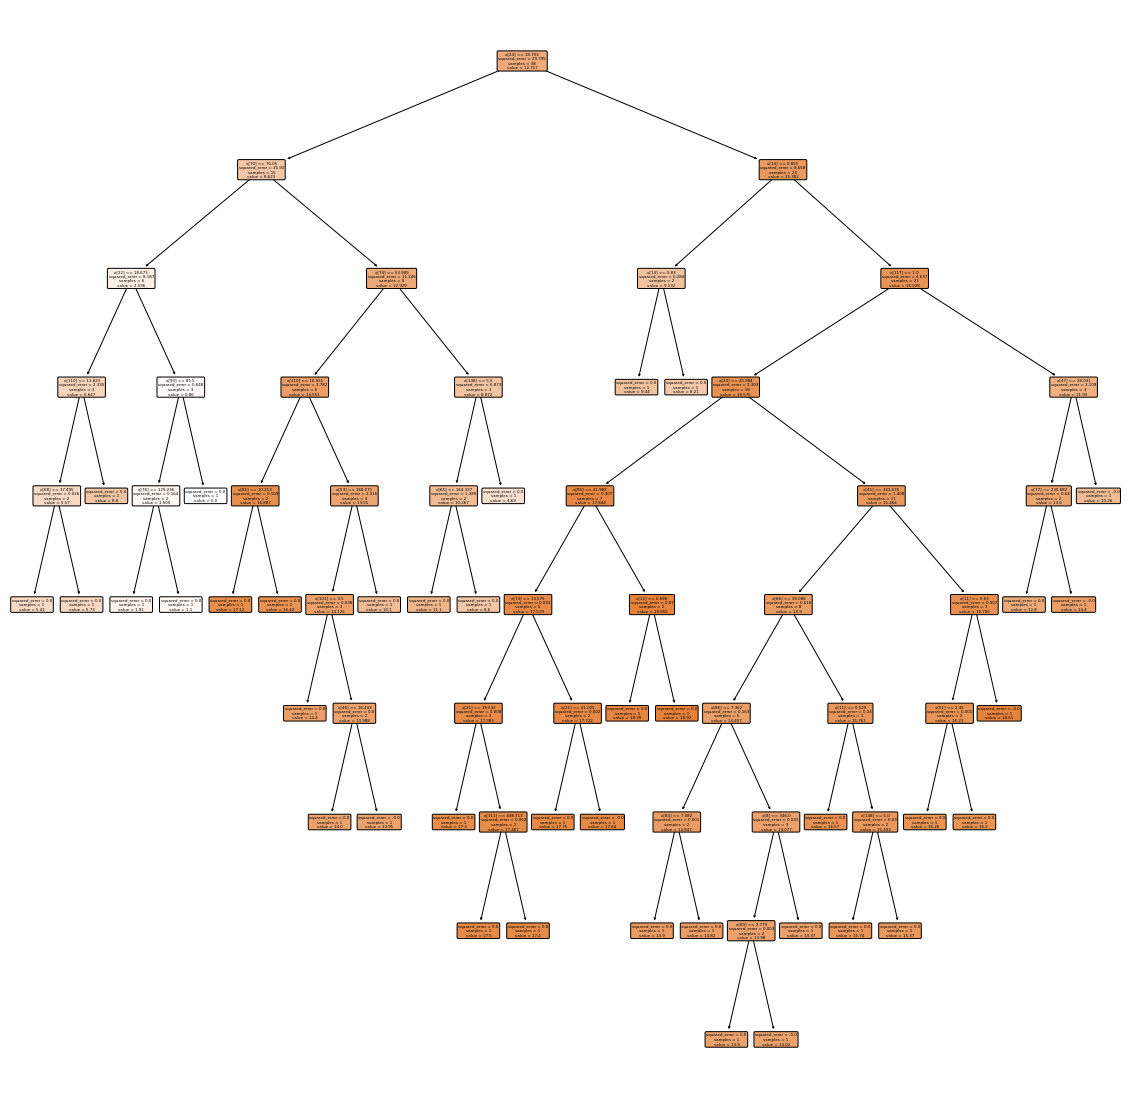

In [83]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


tree = ranf_reg_etl.estimators_[5]

plt.figure(figsize=(20,20))
plot_tree(tree, filled=True, rounded=True)

plt.savefig('tree_high_res.png', dpi=300)

### Features

In [ ]:
importances = ranf_reg_best.feature_importances_

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

descriptor_names = [desc_name[0] for desc_name in Descriptors.descList]

for f in range(X.shape[1]):
    desc_name = descriptor_names[indices[f]]
    print("%d. feature %s (%f)" % (f + 1, desc_name, importances[indices[f]]))

### Multiple labels

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

smiles_list = df['SMILES'].dropna().tolist() 
labels1 = df['PCE (%)'].dropna().tolist()
labels2 = df['Voc (V)'].dropna().tolist()
labels3 = df['Jsc (mA cm-2)'].tolist()
labels5 = df['FF (%)'].tolist()
labels4 = df['ΔΕ (eV)'].tolist()

assert len(smiles_list) == len(labels1) == len(labels2) == len(labels3) == len(labels4)

unique_smiles = []
unique_labels = []
for i, smiles in enumerate(smiles_list):
    if isinstance(smiles, str):
        molecule = Chem.MolFromSmiles(smiles)
        if molecule is not None: 
            canonical_smiles = Chem.MolToSmiles(molecule, canonical=True)
            if canonical_smiles not in unique_smiles:
                unique_smiles.append(canonical_smiles)
                unique_labels.append([labels1[i], labels3[i]])

graphs = []
for smiles in unique_smiles:
    molecule = Chem.MolFromSmiles(smiles)
    atoms = molecule.GetAtoms()
    bonds = molecule.GetBonds()

    nodes = [(atom.GetIdx(), {'symbol': atom.GetSymbol(), 
                              'atomic_num': atom.GetAtomicNum(), 
                              'atomic_mass': atom.GetMass(),
                              'num_valence': atom.GetTotalValence(),
                              'hybridization': atom.GetHybridization(),
                              'in_ring': atom.IsInRing()})
             for atom in atoms]

    edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), {'bond_type': bond.GetBondType()})
             for bond in bonds]

    # Create a graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    graphs.append(G)

feature_vectors = [np.bincount([deg for node, deg in G.degree()]) for G in graphs]

max_len = max(len(f) for f in feature_vectors)
feature_vectors = [np.pad(f, (0, max_len - len(f))) for f in feature_vectors]

features_train, features_test, labels_train, labels_test = train_test_split(feature_vectors, unique_labels, test_size=0.2, random_state=42)

model = MultiOutputRegressor(RandomForestRegressor())
model.fit(features_train, labels_train)

print('Training score:', model.score(features_train, labels_train))
print('Test score:', model.score(features_test, labels_test))


In [ ]:
missing_smiles = df['SMILES'].isnull().sum()
print(f'Missing values in SMILES: {missing_smiles}')

missing_labels1 = df['PCE (%)'].isnull().sum()
print(f'Missing values in PCE (%): {missing_labels1}')

missing_labels2 = df['Voc (V)'].isnull().sum()
print(f'Missing values in HOMO-LUMO Gap: {missing_labels2}')


In [ ]:
df = df.dropna(subset=['SMILES', 'PCE (%)', 'Jsc (mA cm-2)'])

smiles_list = df['SMILES'].tolist()
labels1 = df['PCE (%)'].tolist()
labels2 = df['Voc (V)'].tolist()
labels3 = df['Jsc (mA cm-2)'].tolist()

print(f'Length of SMILES list: {len(smiles_list)}')
print(f'Length of PCE (%) list: {len(labels1)}')
print(f'Length of Voc (V) list: {len(labels2)}')
print(f'Length of Jsc (mA cm-2) list: {len(labels3)}')

In [ ]:
print(len(smiles_list) == len(labels1) == len(labels2))
